# Clustering Analysis

In [1]:
#!pip install "geopandas[all]"

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import os

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
world_map = gpd.read_file("ne_110m_admin_0_countries")

## Data Preparation

In [4]:
df = pd.read_csv(os.path.join("clean_data", "wb_data_combined.csv"))
df = df.drop(columns=["Indicator Code"])
# venzuela is now a lower middle income group
# https://publications.iadb.org/en/venezuela-still-upper-middle-income-country-estimating-gni-capita-2015-2021
df.loc[df["Country Name"] == "Venezuela", "Income Group"] = "Lower middle income"
df = (
    df.pivot_table(
        index=["Country Code", "Country Name", "Region Name", "Income Group", "Year"],
        columns="Indicator Name",
        values="Measure",
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
df = df.drop(
    columns=[
        "Child employment in agriculture (% of economically active children ages 7-14)",
        "Prevalence of moderate or severe food insecurity in the population (%)",
        "Prevalence of severe food insecurity in the population (%)",
    ]
)
df = df.sort_values(["Country Code", "Year"])
df

,Country Code,Country Name,Region Name,Income Group,Year,Access to electricity (% of population),Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)",...,"Prevalence of stunting, height for age (% of children under 5)",Prevalence of undernourishment (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Prevalence of wasting, weight for height (% of children under 5)",Refugee population by country or territory of asylum,Renewable internal freshwater resources per capita (cubic meters),Rural population (% of total population),"School enrollment, primary (% net)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)"
0,ABW,Aruba,Latin America & Caribbean,High income,2000,91.7,7.348765,11.111111,20.0,0.018608,...,18.354545,6.570377,5.28,4.218182,37803.0,26627.141842,53.283,98.086350,9.464672,35.261166
1,ABW,Aruba,Latin America & Caribbean,High income,2001,100.0,8.902187,11.111111,20.0,0.018617,...,17.460000,10.789152,5.14,2.340000,37062.0,26253.769244,53.661,94.539290,9.067957,35.390741
2,ABW,Aruba,Latin America & Caribbean,High income,2002,100.0,6.304310,11.111111,20.0,0.018054,...,18.328571,10.530482,5.00,2.385714,40818.0,25898.688800,54.028,95.318140,9.410192,35.665555
3,ABW,Aruba,Latin America & Caribbean,High income,2003,100.0,6.813288,11.111111,20.0,0.018011,...,19.683333,10.306486,4.86,2.033333,38244.0,25562.946523,54.394,93.930700,9.268500,35.652811
4,ABW,Aruba,Latin America & Caribbean,High income,2004,100.0,6.343244,11.111111,20.0,0.017566,...,14.383333,9.810380,4.73,2.600000,36091.0,25241.299737,54.760,94.634890,8.751598,35.049120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2016,42.5,19.534884,41.876696,162000.0,7.873986,...,32.621429,35.100000,18.06,6.914286,7423.0,848.284169,67.704,82.087283,5.893000,72.744421
4553,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2017,44.0,3.318298,41.876696,162000.0,8.340969,...,26.900000,36.300000,17.70,7.350000,7566.0,831.124402,67.763,82.212440,6.347000,70.969083
4554,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2018,45.4,5.993394,41.876696,162000.0,7.319375,...,32.770000,38.200000,17.33,6.490000,7795.0,814.499743,67.791,85.543158,6.792000,69.536319
4555,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2019,46.7,5.325173,41.876696,162000.0,9.819262,...,23.500000,38.900000,9.70,2.900000,8956.0,798.457375,67.790,86.158230,7.373000,68.043304


In [5]:
fisi = pd.read_csv(os.path.join("clean_data", "fisi.csv"))
fisi = fisi.sort_values(["Country Code", "Year"])
fisi

,Country Code,Country Name,Region Name,Income Group,Year,FISI,Availability_Index,Access_Index,Utilization_Index,Stability_Index,Risk Category
0,ABW,Aruba,Latin America & Caribbean,High income,2000,0.519990,0.859030,0.383548,0.176516,0.232242,medium risk
1,ABW,Aruba,Latin America & Caribbean,High income,2001,0.517346,0.854607,0.387095,0.168661,0.227170,medium risk
2,ABW,Aruba,Latin America & Caribbean,High income,2002,0.520704,0.857450,0.397045,0.167056,0.223681,medium risk
3,ABW,Aruba,Latin America & Caribbean,High income,2003,0.516472,0.854309,0.388736,0.164603,0.222911,medium risk
4,ABW,Aruba,Latin America & Caribbean,High income,2004,0.514546,0.852766,0.385160,0.151908,0.234038,medium risk
...,...,...,...,...,...,...,...,...,...,...,...
4552,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2016,0.619059,0.876950,0.530933,0.367658,0.359006,medium risk
4553,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2017,0.618994,0.892754,0.514434,0.354837,0.362244,medium risk
4554,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2018,0.619024,0.886236,0.519933,0.361130,0.362536,medium risk
4555,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2019,0.620436,0.887768,0.551127,0.295856,0.370746,medium risk


In [6]:
risk_category = fisi["Risk Category"]
risk_category

0       medium risk
1       medium risk
2       medium risk
3       medium risk
4       medium risk
           ...     
4552    medium risk
4553    medium risk
4554    medium risk
4555    medium risk
4556    medium risk
Name: Risk Category, Length: 4557, dtype: object

In [7]:
df = df.merge(fisi, how="inner", on=["Country Code", "Country Name", "Region Name", "Income Group", "Year"])
df

,Country Code,Country Name,Region Name,Income Group,Year,Access to electricity (% of population),Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)",...,Rural population (% of total population),"School enrollment, primary (% net)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)",FISI,Availability_Index,Access_Index,Utilization_Index,Stability_Index,Risk Category
0,ABW,Aruba,Latin America & Caribbean,High income,2000,91.7,7.348765,11.111111,20.0,0.018608,...,53.283,98.086350,9.464672,35.261166,0.519990,0.859030,0.383548,0.176516,0.232242,medium risk
1,ABW,Aruba,Latin America & Caribbean,High income,2001,100.0,8.902187,11.111111,20.0,0.018617,...,53.661,94.539290,9.067957,35.390741,0.517346,0.854607,0.387095,0.168661,0.227170,medium risk
2,ABW,Aruba,Latin America & Caribbean,High income,2002,100.0,6.304310,11.111111,20.0,0.018054,...,54.028,95.318140,9.410192,35.665555,0.520704,0.857450,0.397045,0.167056,0.223681,medium risk
3,ABW,Aruba,Latin America & Caribbean,High income,2003,100.0,6.813288,11.111111,20.0,0.018011,...,54.394,93.930700,9.268500,35.652811,0.516472,0.854309,0.388736,0.164603,0.222911,medium risk
4,ABW,Aruba,Latin America & Caribbean,High income,2004,100.0,6.343244,11.111111,20.0,0.017566,...,54.760,94.634890,8.751598,35.049120,0.514546,0.852766,0.385160,0.151908,0.234038,medium risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2016,42.5,19.534884,41.876696,162000.0,7.873986,...,67.704,82.087283,5.893000,72.744421,0.619059,0.876950,0.530933,0.367658,0.359006,medium risk
4553,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2017,44.0,3.318298,41.876696,162000.0,8.340969,...,67.763,82.212440,6.347000,70.969083,0.618994,0.892754,0.514434,0.354837,0.362244,medium risk
4554,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2018,45.4,5.993394,41.876696,162000.0,7.319375,...,67.791,85.543158,6.792000,69.536319,0.619024,0.886236,0.519933,0.361130,0.362536,medium risk
4555,ZWE,Zimbabwe,Sub-Saharan Africa,Lower middle income,2019,46.7,5.325173,41.876696,162000.0,9.819262,...,67.790,86.158230,7.373000,68.043304,0.620436,0.887768,0.551127,0.295856,0.370746,medium risk


In [8]:
indicators = df.drop(columns=["Country Code", "Country Name", "Risk Category"])
indicators

,Region Name,Income Group,Year,Access to electricity (% of population),Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)","Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)",Arable land (% of land area),...,Renewable internal freshwater resources per capita (cubic meters),Rural population (% of total population),"School enrollment, primary (% net)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)",FISI,Availability_Index,Access_Index,Utilization_Index,Stability_Index
0,Latin America & Caribbean,High income,2000,91.7,7.348765,11.111111,20.0,0.018608,3996.522039,11.111111,...,26627.141842,53.283,98.086350,9.464672,35.261166,0.519990,0.859030,0.383548,0.176516,0.232242
1,Latin America & Caribbean,High income,2001,100.0,8.902187,11.111111,20.0,0.018617,3985.197166,11.111111,...,26253.769244,53.661,94.539290,9.067957,35.390741,0.517346,0.854607,0.387095,0.168661,0.227170
2,Latin America & Caribbean,High income,2002,100.0,6.304310,11.111111,20.0,0.018054,4043.814390,11.111111,...,25898.688800,54.028,95.318140,9.410192,35.665555,0.520704,0.857450,0.397045,0.167056,0.223681
3,Latin America & Caribbean,High income,2003,100.0,6.813288,11.111111,20.0,0.018011,4268.802968,11.111111,...,25562.946523,54.394,93.930700,9.268500,35.652811,0.516472,0.854309,0.388736,0.164603,0.222911
4,Latin America & Caribbean,High income,2004,100.0,6.343244,11.111111,20.0,0.017566,4251.930792,11.111111,...,25241.299737,54.760,94.634890,8.751598,35.049120,0.514546,0.852766,0.385160,0.151908,0.234038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,Sub-Saharan Africa,Lower middle income,2016,42.5,19.534884,41.876696,162000.0,7.873986,471.621105,10.339925,...,848.284169,67.704,82.087283,5.893000,72.744421,0.619059,0.876950,0.530933,0.367658,0.359006
4553,Sub-Saharan Africa,Lower middle income,2017,44.0,3.318298,41.876696,162000.0,8.340969,513.973171,10.339925,...,831.124402,67.763,82.212440,6.347000,70.969083,0.618994,0.892754,0.514434,0.354837,0.362244
4554,Sub-Saharan Africa,Lower middle income,2018,45.4,5.993394,41.876696,162000.0,7.319375,607.312224,10.339925,...,814.499743,67.791,85.543158,6.792000,69.536319,0.619024,0.886236,0.519933,0.361130,0.362536
4555,Sub-Saharan Africa,Lower middle income,2019,46.7,5.325173,41.876696,162000.0,9.819262,542.907293,10.339925,...,798.457375,67.790,86.158230,7.373000,68.043304,0.620436,0.887768,0.551127,0.295856,0.370746


In [9]:
# indicators = indicators.drop(columns=["Income Group", "Region Name"])
indicators = pd.get_dummies(indicators, dtype=int)
indicators = indicators.drop(columns="Year")
indicators

,Access to electricity (% of population),Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)","Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)",Arable land (% of land area),Arable land (hectares per person),Average precipitation in depth (mm per year),Cereal production (metric tons),...,Region Name_Europe & Central Asia,Region Name_Latin America & Caribbean,Region Name_Middle East & North Africa,Region Name_North America,Region Name_South Asia,Region Name_Sub-Saharan Africa,Income Group_High income,Income Group_Low income,Income Group_Lower middle income,Income Group_Upper middle income
0,91.7,7.348765,11.111111,20.0,0.018608,3996.522039,11.111111,0.022446,1792.941176,1.377060e+08,...,0,1,0,0,0,0,1,0,0,0
1,100.0,8.902187,11.111111,20.0,0.018617,3985.197166,11.111111,0.022053,1818.117647,1.515257e+08,...,0,1,0,0,0,0,1,0,0,0
2,100.0,6.304310,11.111111,20.0,0.018054,4043.814390,11.111111,0.021791,1817.500000,1.417696e+08,...,0,1,0,0,0,0,1,0,0,0
3,100.0,6.813288,11.111111,20.0,0.018011,4268.802968,11.111111,0.021575,1818.117647,1.607484e+08,...,0,1,0,0,0,0,1,0,0,0
4,100.0,6.343244,11.111111,20.0,0.017566,4251.930792,11.111111,0.021381,1818.117647,1.609028e+08,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,42.5,19.534884,41.876696,162000.0,7.873986,471.621105,10.339925,0.276765,657.000000,6.767474e+05,...,0,0,0,0,0,1,0,0,1,0
4553,44.0,3.318298,41.876696,162000.0,8.340969,513.973171,10.339925,0.271166,657.000000,1.748339e+06,...,0,0,0,0,0,1,0,0,1,0
4554,45.4,5.993394,41.876696,162000.0,7.319375,607.312224,10.339925,0.265742,657.000000,1.780369e+06,...,0,0,0,0,0,1,0,0,1,0
4555,46.7,5.325173,41.876696,162000.0,9.819262,542.907293,10.339925,0.260508,657.000000,1.026006e+06,...,0,0,0,0,0,1,0,0,1,0


In [10]:
indicators.describe()

,Access to electricity (% of population),Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)","Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)",Arable land (% of land area),Arable land (hectares per person),Average precipitation in depth (mm per year),Cereal production (metric tons),...,Region Name_Europe & Central Asia,Region Name_Latin America & Caribbean,Region Name_Middle East & North Africa,Region Name_North America,Region Name_South Asia,Region Name_Sub-Saharan Africa,Income Group_High income,Income Group_Low income,Income Group_Lower middle income,Income Group_Upper middle income
count,4557.000000,4557.000000,4557.000000,4.557000e+03,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4.557000e+03,...,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000
mean,80.636684,10.581595,37.151717,5.061738e+05,10.597371,11731.811600,13.592968,0.200998,1222.655596,9.818565e+07,...,0.267281,0.193548,0.096774,0.013825,0.036866,0.221198,0.391705,0.119816,0.239631,0.248848
std,29.450602,9.670888,21.816042,1.614164e+06,10.731789,18500.451237,13.180800,0.227436,770.218295,2.177740e+08,...,0.442589,0.395122,0.295682,0.116776,0.188454,0.415099,0.488185,0.324781,0.426905,0.432393
min,0.800000,0.000000,0.448718,3.000000e+00,0.012520,158.551906,0.043141,0.000098,18.100000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.400000,4.489723,18.994219,2.024000e+03,2.360203,1827.884030,3.473278,0.049573,624.000000,3.054360e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,98.800000,7.882800,37.676493,3.198000e+04,6.410721,4822.758123,9.892094,0.138781,1110.000000,2.960073e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,13.649024,52.740811,2.284200e+05,16.199760,12038.255535,18.932114,0.259831,1821.000000,3.431319e+07,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,100.000000,79.361402,85.487373,1.250502e+07,79.042362,127759.340553,64.146885,2.026341,3240.000000,9.351992e+08,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
feature_max_vals = indicators.max(axis=0)
feature_min_vals = indicators.min(axis=0)
indicators = (indicators - feature_min_vals) / (feature_max_vals - feature_min_vals)
indicators

,Access to electricity (% of population),Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),Agricultural land (sq. km),"Agriculture, forestry, and fishing, value added (% of GDP)","Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)",Arable land (% of land area),Arable land (hectares per person),Average precipitation in depth (mm per year),Cereal production (metric tons),...,Region Name_Europe & Central Asia,Region Name_Latin America & Caribbean,Region Name_Middle East & North Africa,Region Name_North America,Region Name_South Asia,Region Name_Sub-Saharan Africa,Income Group_High income,Income Group_Low income,Income Group_Lower middle income,Income Group_Upper middle income
0,0.916331,0.092599,0.125383,0.000001,0.000077,0.030078,0.172657,0.011029,0.550868,0.147248,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.000000,0.112173,0.125383,0.000001,0.000077,0.029989,0.172657,0.010835,0.558682,0.162025,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.000000,0.079438,0.125383,0.000001,0.000070,0.030449,0.172657,0.010706,0.558490,0.151593,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.000000,0.085851,0.125383,0.000001,0.000069,0.032212,0.172657,0.010599,0.558682,0.171887,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.000000,0.079929,0.125383,0.000001,0.000064,0.032080,0.172657,0.010504,0.558682,0.172052,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,0.420363,0.246151,0.487166,0.012955,0.099475,0.002454,0.160627,0.136542,0.198299,0.000724,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4553,0.435484,0.041812,0.487166,0.012955,0.105384,0.002785,0.160627,0.133779,0.198299,0.001869,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4554,0.449597,0.075520,0.487166,0.012955,0.092457,0.003517,0.160627,0.131102,0.198299,0.001904,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4555,0.462702,0.067100,0.487166,0.012955,0.124089,0.003012,0.160627,0.128519,0.198299,0.001097,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Visualize existing clusters in data

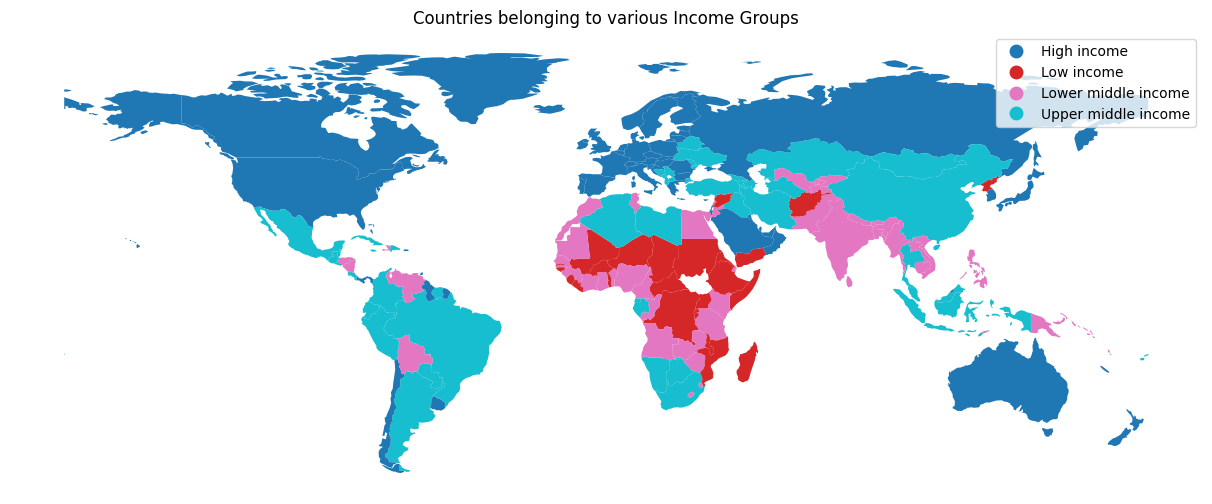

In [12]:
fig, ax = plt.subplots(figsize=(30, 6))
country_data = df[["Country Code", "Income Group"]].drop_duplicates()
country_data = {
    record["Country Code"]: record["Income Group"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    #missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(
    f"Countries belonging to various Income Groups"
)

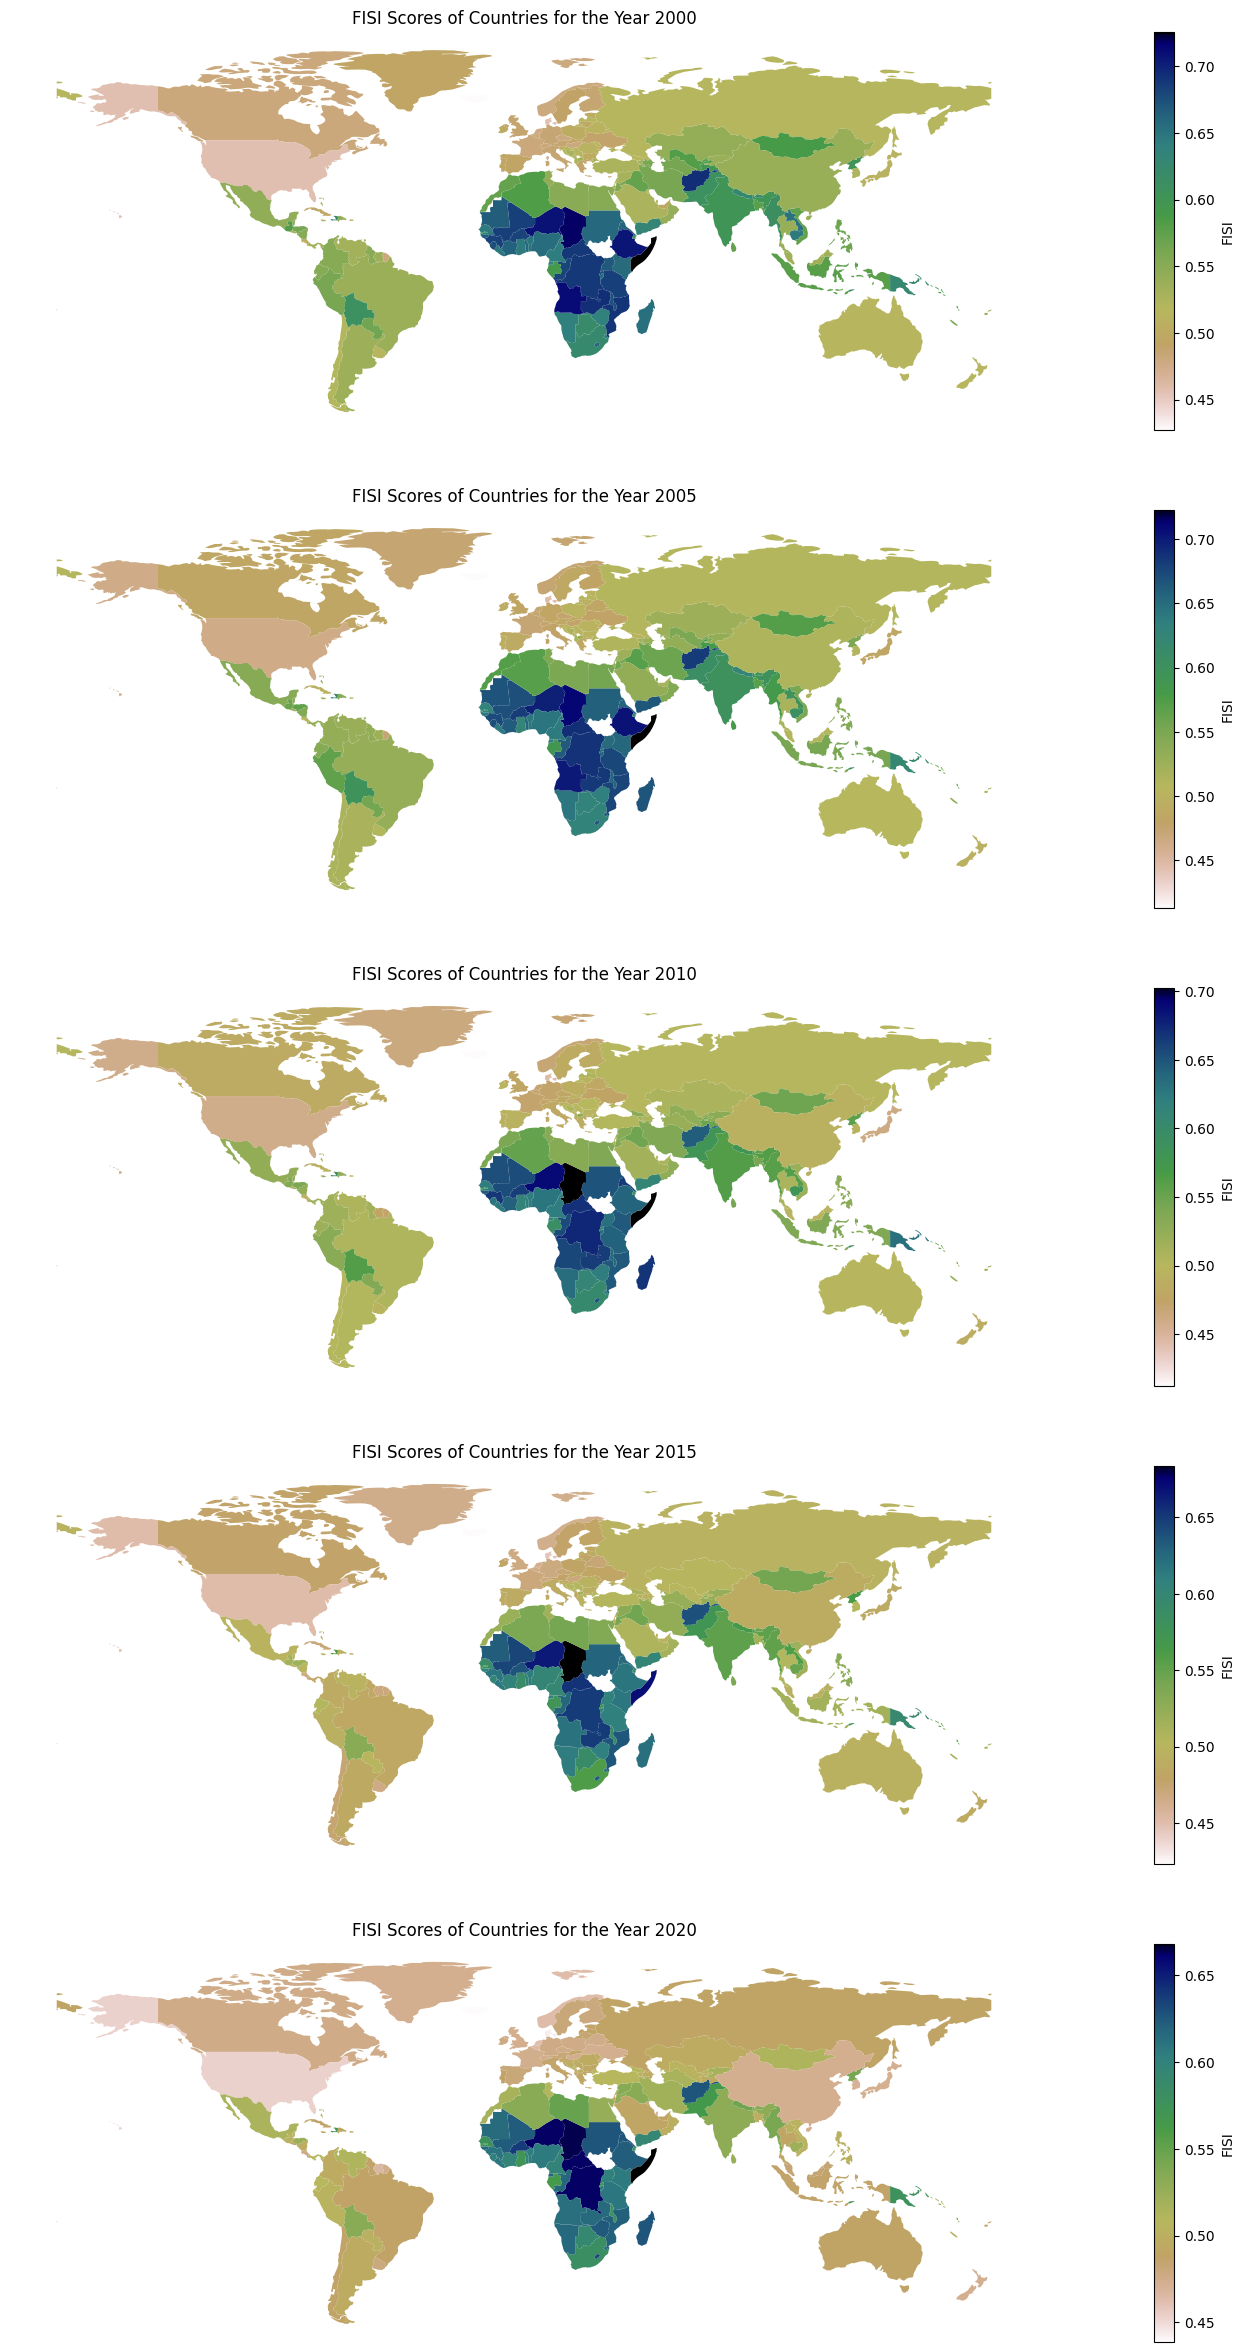

In [13]:
fig, ax = plt.subplots(5, 1, figsize=(30, 30))
for idx, year in enumerate(range(2000, 2021, 5)):
    country_data = df[df["Year"] == year][
        ["Country Code", "FISI"]
    ]
    country_data = {
        record["Country Code"]: record["FISI"]
        for record in country_data.to_dict(orient="records")
    }
    world_map["values"] = world_map["ADM0_A3"].map(country_data)
    world_map.plot(
        column="values",
        ax=ax[idx],
        legend=True,
        legend_kwds={"label": "FISI"},
        #missing_kwds={"color": "lightgrey"},
        cmap="gist_earth_r",
    )
    _ = ax[idx].axis("off")
    _ = ax[idx].set_title(f"FISI Scores of Countries for the Year {year}")

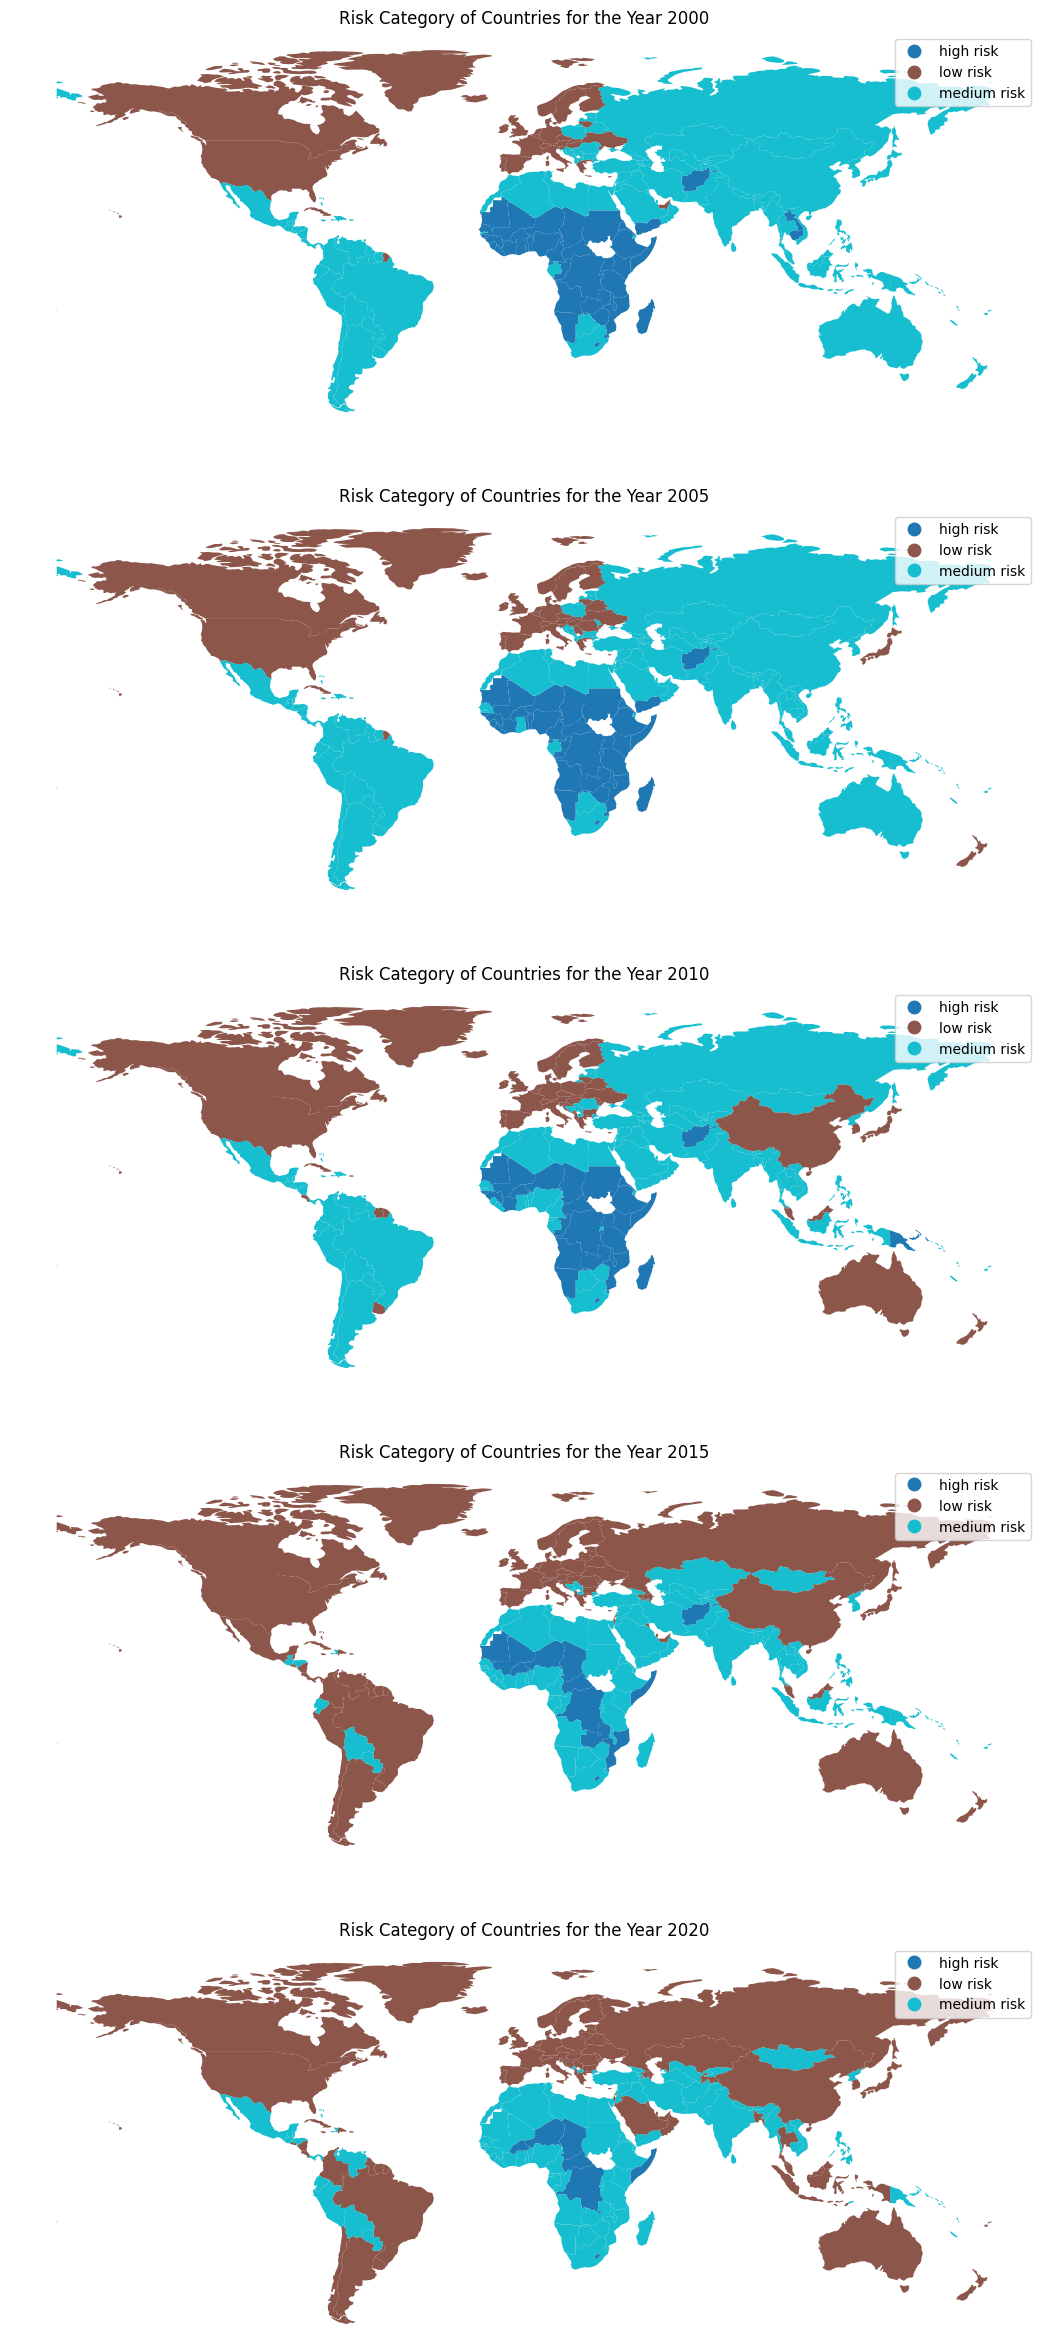

In [14]:
fig, ax = plt.subplots(5, 1, figsize=(30, 30))
for idx, year in enumerate(range(2000, 2021, 5)):
    country_data = df[df["Year"] == year][
        ["Country Code", "Risk Category"]
    ]
    country_data = {
        record["Country Code"]: record["Risk Category"]
        for record in country_data.to_dict(orient="records")
    }
    world_map["values"] = world_map["ADM0_A3"].map(country_data)
    world_map.plot(
        column="values",
        ax=ax[idx],
        legend=True,
        #missing_kwds={"color": "lightgrey"},
        cmap="tab10",
    )
    _ = ax[idx].axis("off")
    _ = ax[idx].set_title(f"Risk Category of Countries for the Year {year}")

## PCA Visualization of Data

In [15]:
pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(indicators.values)
X_pca.shape

(4557, 8)

In [16]:
pca.explained_variance_ratio_

array([0.3769737 , 0.11188841, 0.09257181, 0.07983987, 0.06488532,
       0.0494282 , 0.0314436 , 0.02354549])

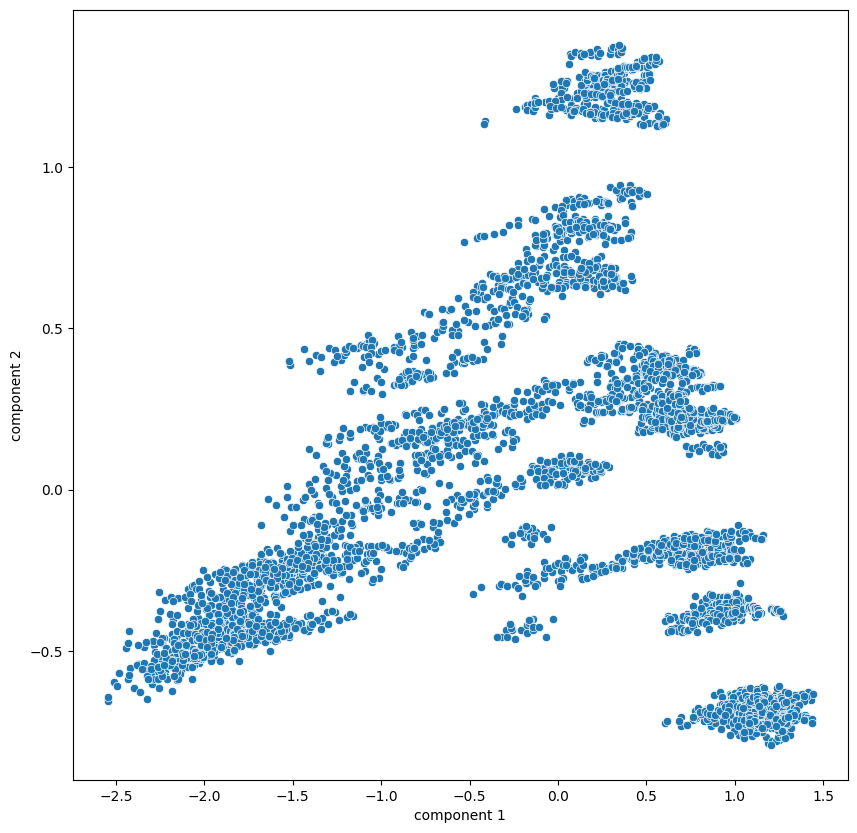

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax1 = 0
ax2 = 1
plot_data = pd.DataFrame(
    {
        f"component {ax1+1}": X_pca[:, ax1],
        f"component {ax2+1}": X_pca[:, ax2],
    }
)
_ = sns.scatterplot(plot_data, x=f"component {ax1+1}", y=f"component {ax2+1}", ax=ax)

## K-Means Clustering (for equal size clusters)

In [18]:
metrics = {
    "n_clusters": [],
    "objective": [],
    "silhouette": []
}
for n_clusters in range(2, 30):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42).fit(indicators.values)
    metrics["n_clusters"].append(n_clusters)
    metrics["objective"].append(kmeans.inertia_)
    silhouette = silhouette_score(indicators.values, kmeans.labels_)
    metrics["silhouette"].append(silhouette)
    print(n_clusters, f"objective[{kmeans.inertia_}]", f"silhouette[{silhouette}]")

2 objective[9305.718175925143] silhouette[0.3058029271287117]
3 objective[7713.061660899583] silhouette[0.2535458642035062]
4 objective[6977.068432614692] silhouette[0.2603069174160616]
5 objective[6192.263323127588] silhouette[0.2715996750012909]
6 objective[5789.157741098194] silhouette[0.26143864405916334]
7 objective[5471.543621678289] silhouette[0.2776913124992781]
8 objective[4762.47450600389] silhouette[0.3097555694730979]
9 objective[4470.217079303248] silhouette[0.3207826293747587]
10 objective[4297.69756907612] silhouette[0.32184317044491834]
11 objective[3739.254270332216] silhouette[0.36531170542676733]
12 objective[3688.6831382870014] silhouette[0.3455097452371506]
13 objective[3626.522968038854] silhouette[0.322207764868628]
14 objective[3423.9477329661668] silhouette[0.3317538059348683]
15 objective[3181.2374112133175] silhouette[0.3464816277299052]
16 objective[2994.6959702123527] silhouette[0.3583075838917154]
17 objective[2952.349753745054] silhouette[0.33758946373735

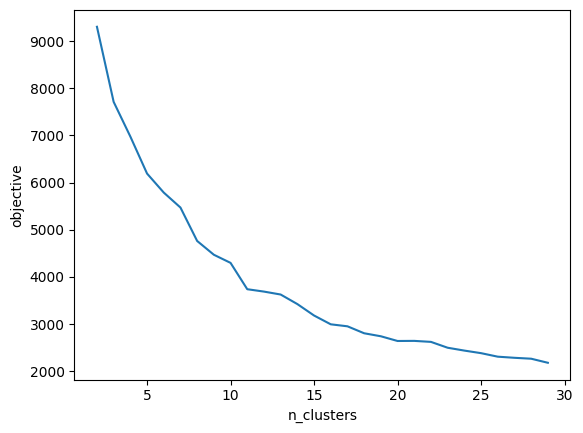

In [19]:
metrics = pd.DataFrame(metrics)
_ = sns.lineplot(metrics, x="n_clusters", y="objective")

In [20]:
kmeans = KMeans(n_clusters=11, init="k-means++", random_state=42)
kmeans_labels = kmeans.fit_predict(indicators.values)

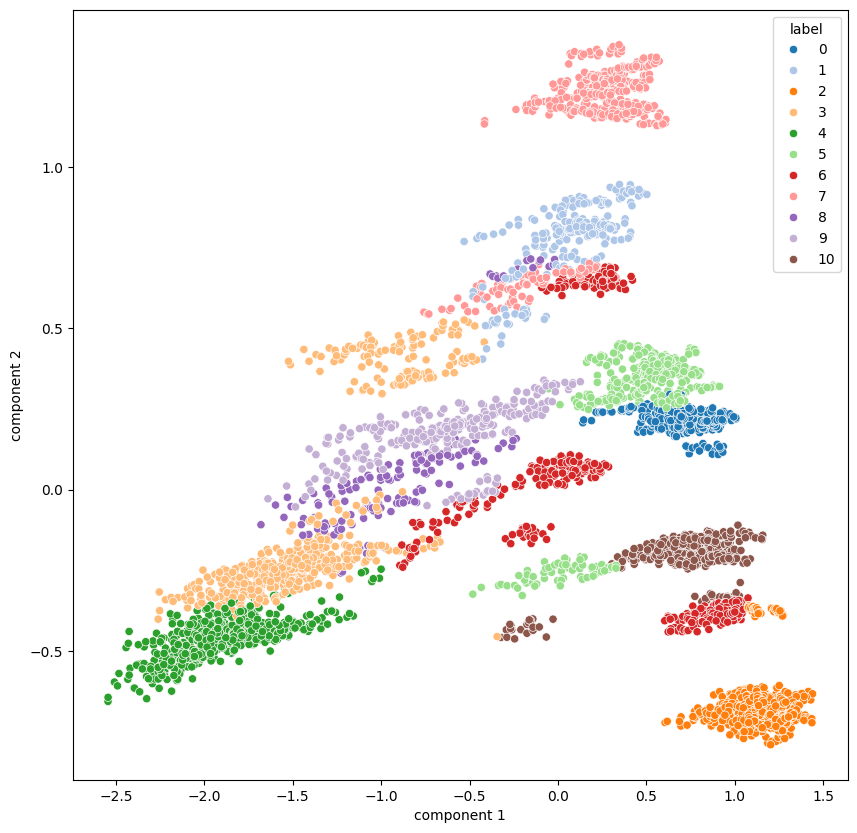

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax1 = 0
ax2 = 1
plot_data = pd.DataFrame(
    {
        f"component {ax1+1}": X_pca[:, ax1],
        f"component {ax2+1}": X_pca[:, ax2],
        "label": kmeans_labels,
    }
)
_ = sns.scatterplot(
    plot_data,
    x=f"component {ax1+1}",
    y=f"component {ax2+1}",
    hue="label",
    palette="tab20",
    ax=ax,
)

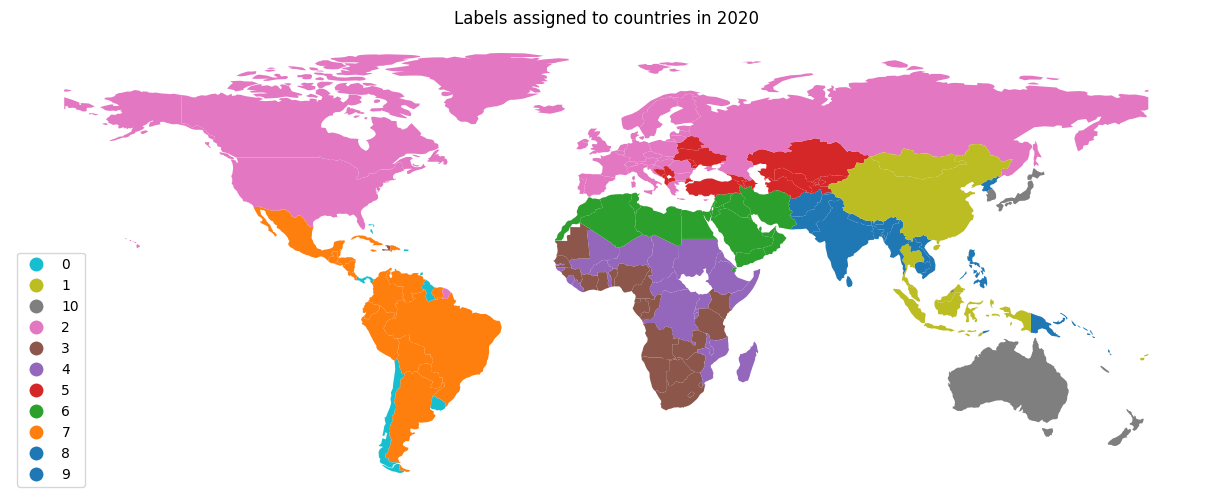

In [36]:
year = 2020
tdf = pd.DataFrame(
    {
        "Country Code": df[df["Year"] == year]["Country Code"],
        "Label": kmeans_labels[df["Year"] == year],
    }
)
fig, ax = plt.subplots(figsize=(30, 6))
country_data = tdf.drop_duplicates()
country_data = {
    record["Country Code"]: f"{record["Label"]}"
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    legend_kwds = {'loc': 'lower left'},
    # legend_kwds={"label": "K-Means Label"},
    #missing_kwds={"color": "lightgrey"},
    cmap="tab10_r",
)
_ = ax.axis("off")
_ = ax.set_title(f"Labels assigned to countries in {year}")

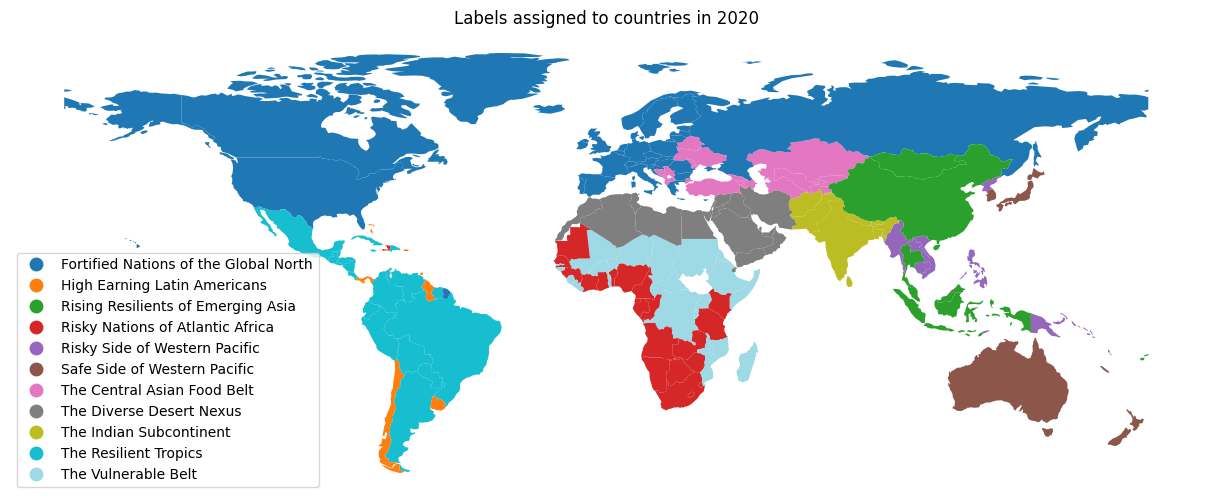

In [41]:
label_names = {
	0: "High Earning Latin Americans",
	1: "Rising Resilients of Emerging Asia",
	2: "Fortified Nations of the Global North",
	3: "Risky Nations of Atlantic Africa",
	4: "The Vulnerable Belt",
	5: "The Central Asian Food Belt",
	6: "The Diverse Desert Nexus",
	7: "The Resilient Tropics",
	8: "The Indian Subcontinent",
	9: "Risky Side of Western Pacific",
	10: "Safe Side of Western Pacific"
}
year = 2020
tdf = pd.DataFrame(
    {
        "Country Code": df[df["Year"] == year]["Country Code"],
        "Label": kmeans_labels[df["Year"] == year],
    }
)
fig, ax = plt.subplots(figsize=(30, 6))
country_data = tdf.drop_duplicates()
country_data = {
    record["Country Code"]: label_names[record["Label"]]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    legend_kwds = {'loc': 'lower left'},
    # legend_kwds={"label": "K-Means Label"},
    #missing_kwds={"color": "lightgrey"},
    cmap="tab20",
)
_ = ax.axis("off")
_ = ax.set_title(f"Labels assigned to countries in {year}")

## Explore Label 0

Countries in Label 0 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 0 belong to - ['medium risk', 'low risk'] food security categories
Countries in Label 0 belong to - ['Latin America & Caribbean'] regions
Countries in Label 0 belong to - ['High income'] income group


,Country Name,Region Name
0,Aruba,Latin America & Caribbean
189,Antigua and Barbuda,Latin America & Caribbean
420,The Bahamas,Latin America & Caribbean
567,Barbados,Latin America & Caribbean
735,Chile,Latin America & Caribbean
966,Curaçao,Latin America & Caribbean
987,Cayman Islands,Latin America & Caribbean
1701,Guyana,Latin America & Caribbean
2184,St. Kitts and Nevis,Latin America & Caribbean
2499,St. Martin (French part),Latin America & Caribbean


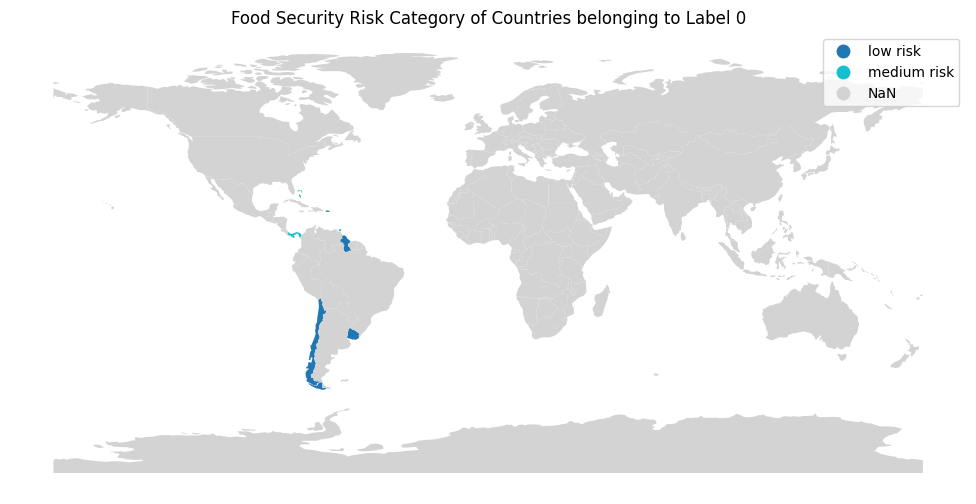

In [34]:
label = 0
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 1

Countries in Label 1 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 1 belong to - ['medium risk', 'low risk'] food security categories
Countries in Label 1 belong to - ['East Asia & Pacific', 'South Asia', 'Sub-Saharan Africa'] regions
Countries in Label 1 belong to - ['Upper middle income'] income group


,Country Name,Region Name
756,China,East Asia & Pacific
1323,Fiji,East Asia & Pacific
1827,Indonesia,East Asia & Pacific
2613,Maldives,South Asia
2646,Marshall Islands,East Asia & Pacific
2772,Mongolia,East Asia & Pacific
2856,Mauritius,Sub-Saharan Africa
2898,Malaysia,East Asia & Pacific
3990,Thailand,East Asia & Pacific
4074,Tonga,East Asia & Pacific


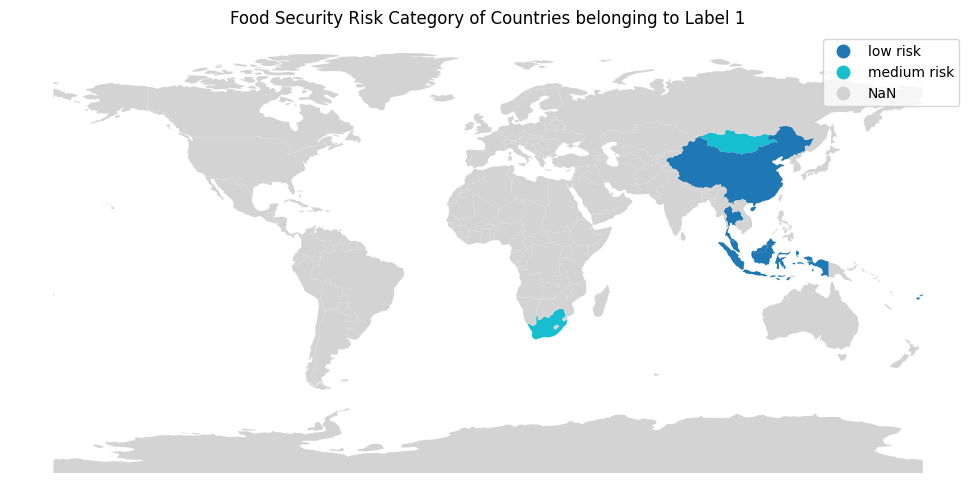

In [35]:
label = 1
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

Maldives is not vivible in the map because it is very small. It is not even visible clearly on the Google maps.

## Explore Label 2

Countries in Label 2 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 2 belong to - ['low risk', 'medium risk'] food security categories
Countries in Label 2 belong to - ['Europe & Central Asia', 'North America'] regions
Countries in Label 2 belong to - ['High income'] income group


,Country Name,Region Name
84,Andorra,Europe & Central Asia
231,Austria,Europe & Central Asia
294,Belgium,Europe & Central Asia
378,Bulgaria,Europe & Central Asia
504,Bermuda,North America
672,Canada,North America
693,Switzerland,Europe & Central Asia
714,Channel Islands,Europe & Central Asia
1008,Cyprus,Europe & Central Asia
1029,Czechia,Europe & Central Asia


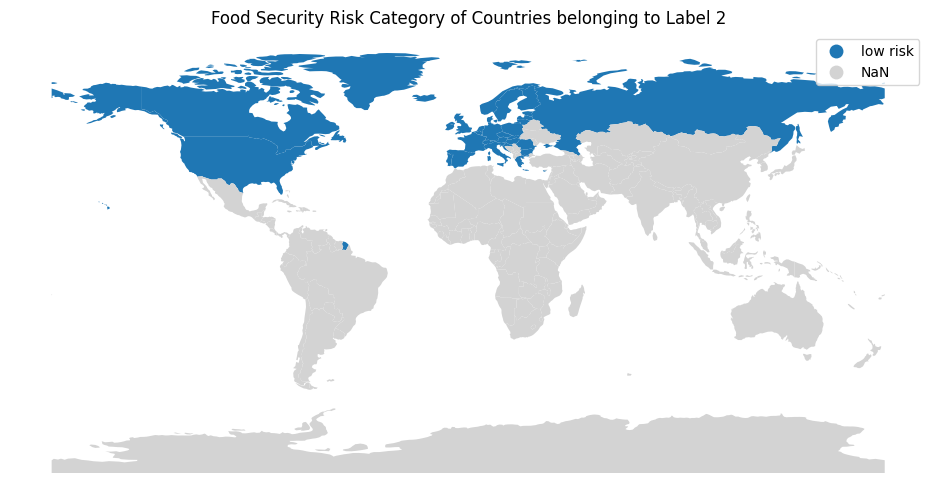

In [25]:
label = 2
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 3

Countries in Label 3 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 3 belong to - ['high risk', 'medium risk'] food security categories
Countries in Label 3 belong to - ['Sub-Saharan Africa', 'Latin America & Caribbean'] regions
Countries in Label 3 belong to - ['Lower middle income', 'Upper middle income', 'High income'] income group


,Country Name,Region Name
42,Angola,Sub-Saharan Africa
315,Benin,Sub-Saharan Africa
630,Botswana,Sub-Saharan Africa
777,Côte d'Ivoire,Sub-Saharan Africa
798,Cameroon,Sub-Saharan Africa
840,Congo,Sub-Saharan Africa
882,Comoros,Sub-Saharan Africa
903,Cabo Verde,Sub-Saharan Africa
1407,Gabon,Sub-Saharan Africa
1470,Ghana,Sub-Saharan Africa


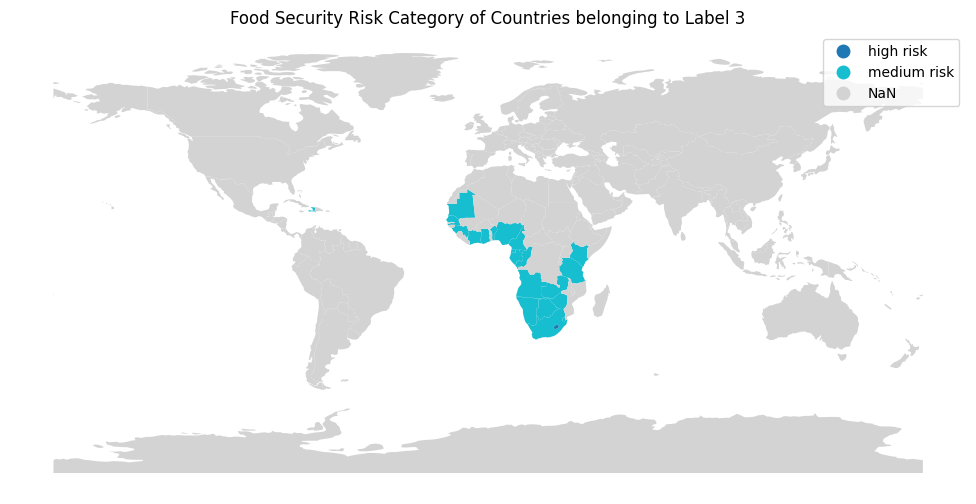

In [26]:
label = 3
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 4

Countries in Label 4 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 4 belong to - ['high risk', 'medium risk'] food security categories
Countries in Label 4 belong to - ['South Asia', 'Sub-Saharan Africa', 'Middle East & North Africa'] regions
Countries in Label 4 belong to - ['Low income'] income group


,Country Name,Region Name
21,Afghanistan,South Asia
273,Burundi,Sub-Saharan Africa
336,Burkina Faso,Sub-Saharan Africa
651,Central African Republic,Sub-Saharan Africa
819,Dem. Rep. Congo,Sub-Saharan Africa
1218,Eritrea,Sub-Saharan Africa
1281,Ethiopia,Sub-Saharan Africa
1533,The Gambia,Sub-Saharan Africa
1554,Guinea-Bissau,Sub-Saharan Africa
2289,Liberia,Sub-Saharan Africa


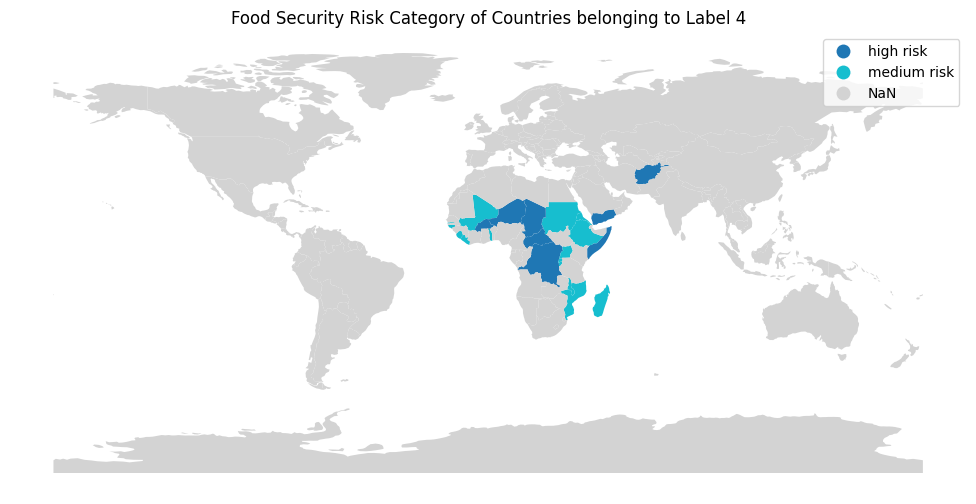

In [27]:
label = 4
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 5

Countries in Label 5 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 5 belong to - ['medium risk', 'low risk'] food security categories
Countries in Label 5 belong to - ['Europe & Central Asia'] regions
Countries in Label 5 belong to - ['Upper middle income', 'Lower middle income'] income group


,Country Name,Region Name
63,Albania,Europe & Central Asia
147,Armenia,Europe & Central Asia
252,Azerbaijan,Europe & Central Asia
441,Bosnia and Herzegovina,Europe & Central Asia
462,Belarus,Europe & Central Asia
1449,Georgia,Europe & Central Asia
2079,Kazakhstan,Europe & Central Asia
2121,Kyrgyz Republic,Europe & Central Asia
2562,Moldova,Europe & Central Asia
2667,North Macedonia,Europe & Central Asia


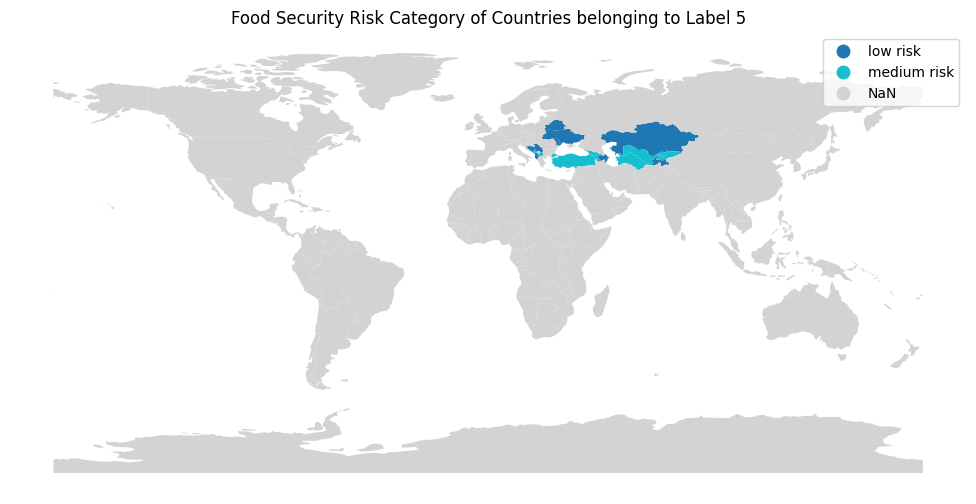

In [28]:
label = 5
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 6

Countries in Label 6 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 6 belong to - ['low risk', 'medium risk'] food security categories
Countries in Label 6 belong to - ['Middle East & North Africa'] regions
Countries in Label 6 belong to - ['High income', 'Lower middle income', 'Upper middle income', 'Low income'] income group


,Country Name,Region Name
105,United Arab Emirates,Middle East & North Africa
399,Bahrain,Middle East & North Africa
1071,Djibouti,Middle East & North Africa
1155,Algeria,Middle East & North Africa
1197,Egypt,Middle East & North Africa
1911,Iran,Middle East & North Africa
1932,Iraq,Middle East & North Africa
1974,Israel,Middle East & North Africa
2037,Jordan,Middle East & North Africa
2226,Kuwait,Middle East & North Africa


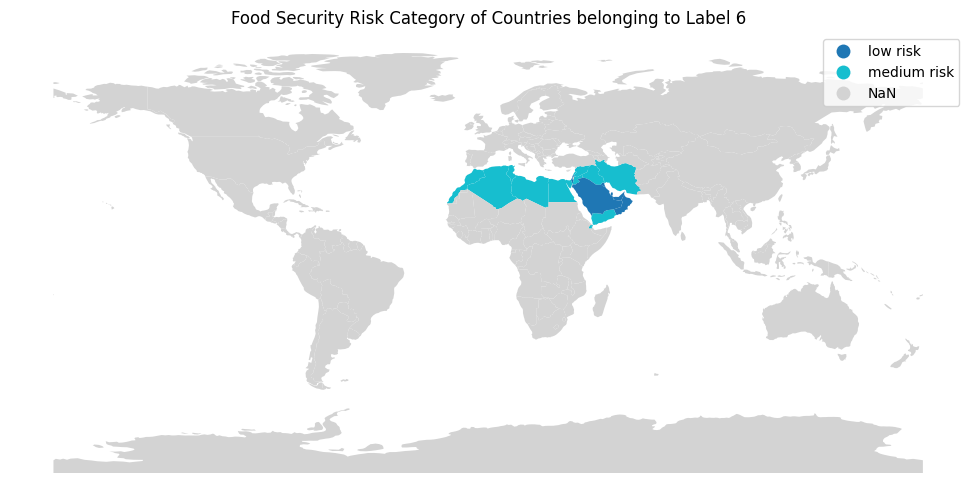

In [29]:
label = 6
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 7

Countries in Label 7 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 7 belong to - ['medium risk', 'low risk'] food security categories
Countries in Label 7 belong to - ['Latin America & Caribbean'] regions
Countries in Label 7 belong to - ['Upper middle income', 'Lower middle income'] income group


,Country Name,Region Name
126,Argentina,Latin America & Caribbean
483,Belize,Latin America & Caribbean
525,Bolivia,Latin America & Caribbean
546,Brazil,Latin America & Caribbean
861,Colombia,Latin America & Caribbean
924,Costa Rica,Latin America & Caribbean
945,Cuba,Latin America & Caribbean
1092,Dominica,Latin America & Caribbean
1134,Dominican Republic,Latin America & Caribbean
1176,Ecuador,Latin America & Caribbean


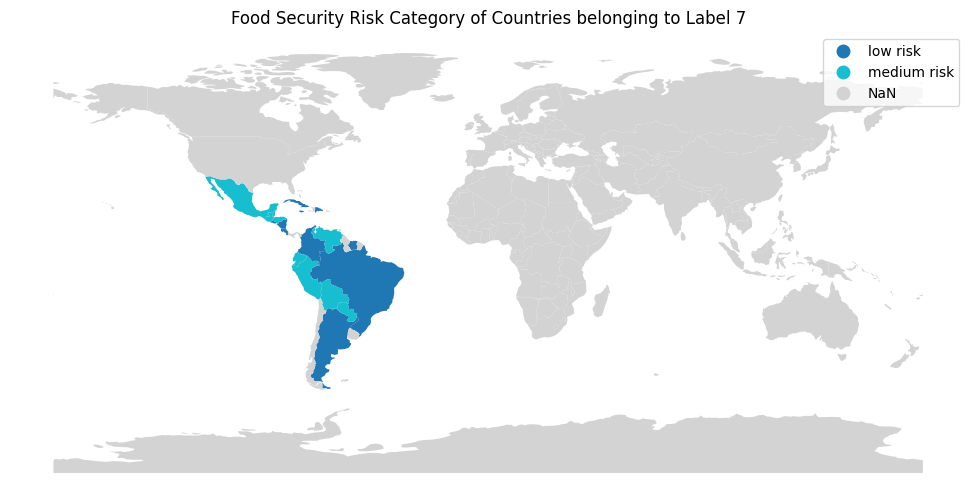

In [30]:
label = 7
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 8

Countries in Label 8 belong to - [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011] years
Countries in Label 8 belong to - ['high risk', 'medium risk', 'low risk'] food security categories
Countries in Label 8 belong to - ['South Asia'] regions
Countries in Label 8 belong to - ['Low income', 'Lower middle income', 'Upper middle income'] income group


,Country Name,Region Name
33,Afghanistan,South Asia
357,Bangladesh,South Asia
609,Bhutan,South Asia
1869,India,South Asia
2373,Sri Lanka,South Asia
2604,Maldives,South Asia
3066,Nepal,South Asia
3150,Pakistan,South Asia


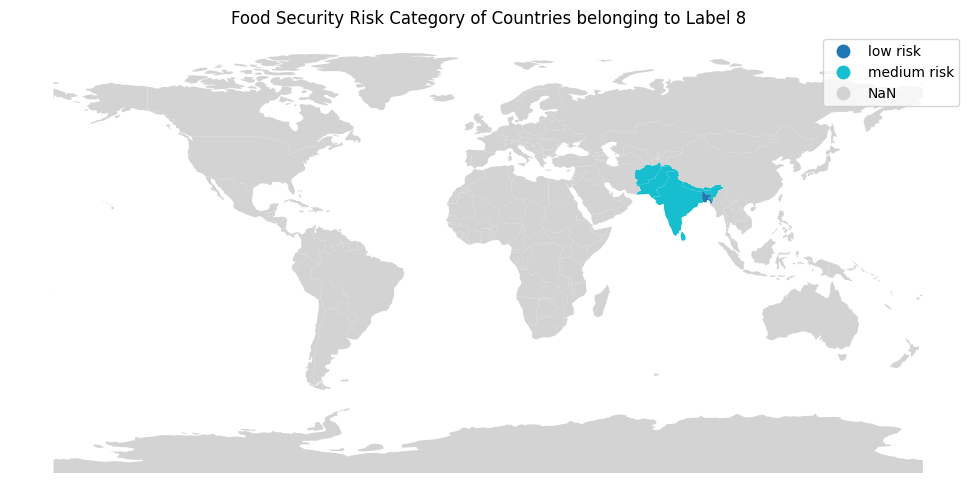

In [31]:
label = 8
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 9

Countries in Label 9 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 9 belong to - ['medium risk', 'high risk', 'low risk'] food security categories
Countries in Label 9 belong to - ['East Asia & Pacific'] regions
Countries in Label 9 belong to - ['Lower middle income', 'Low income'] income group


,Country Name,Region Name
1386,Micronesia,East Asia & Pacific
2142,Cambodia,East Asia & Pacific
2163,Kiribati,East Asia & Pacific
2247,Lao PDR,East Asia & Pacific
2730,Myanmar,East Asia & Pacific
3213,Philippines,East Asia & Pacific
3255,Papua New Guinea,East Asia & Pacific
3318,Dem. People's Rep. Korea,East Asia & Pacific
3591,Solomon Islands,East Asia & Pacific
4053,Timor-Leste,East Asia & Pacific


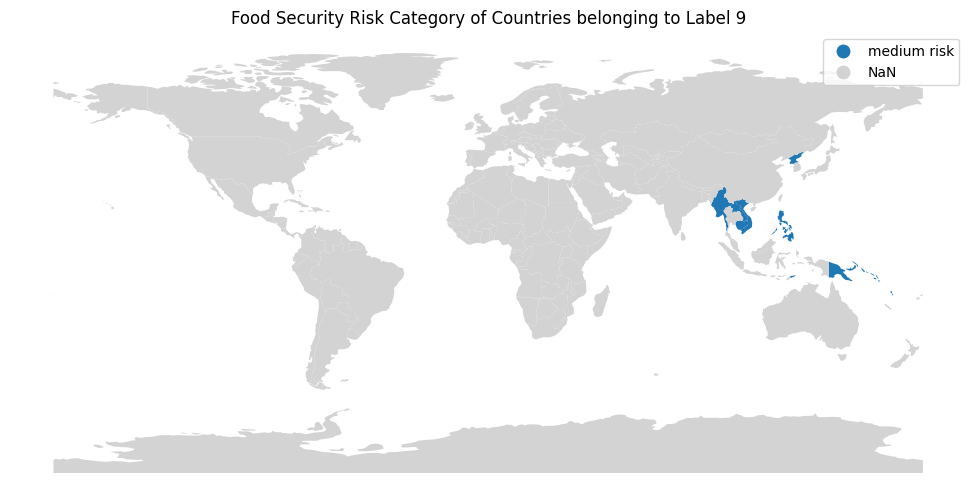

In [32]:
label = 9
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

## Explore Label 10

Countries in Label 10 belong to - [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] years
Countries in Label 10 belong to - ['medium risk', 'low risk'] food security categories
Countries in Label 10 belong to - ['East Asia & Pacific', 'Sub-Saharan Africa'] regions
Countries in Label 10 belong to - ['High income'] income group


,Country Name,Region Name
168,American Samoa,East Asia & Pacific
210,Australia,East Asia & Pacific
588,Brunei,East Asia & Pacific
1680,Guam,East Asia & Pacific
1722,"Hong Kong SAR, China",East Asia & Pacific
2058,Japan,East Asia & Pacific
2205,Korea,East Asia & Pacific
2478,"Macao SAR, China",East Asia & Pacific
2793,Northern Mariana Islands,East Asia & Pacific
2940,New Caledonia,East Asia & Pacific


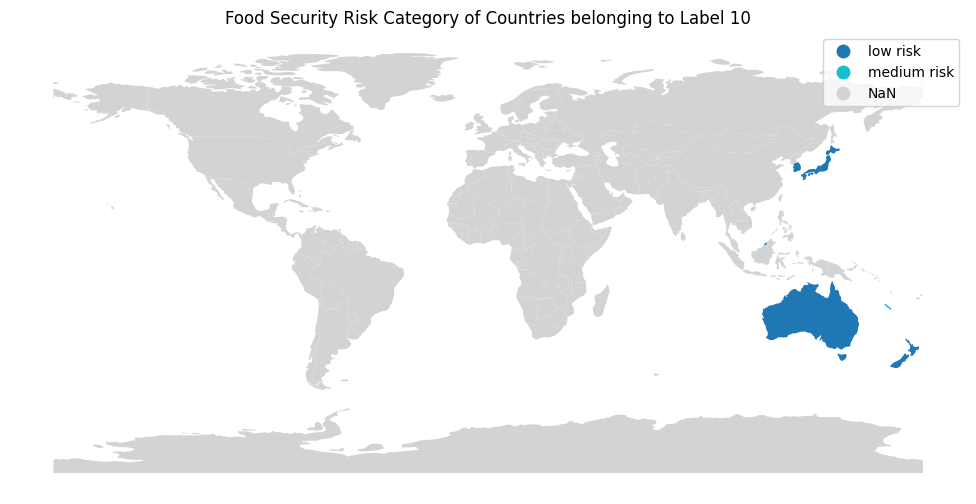

In [33]:
label = 10
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Year"].unique().tolist()} years"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Risk Category"].unique().tolist()} food security categories"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Region Name"].unique().tolist()} regions"
)
print(
    f"Countries in Label {label} belong to - {df[kmeans_labels == label]["Income Group"].unique().tolist()} income group"
)
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
country_data = df[kmeans_labels == label][["Country Code", "Risk Category"]]
country_data = {
    record["Country Code"]: record["Risk Category"]
    for record in country_data.to_dict(orient="records")
}
world_map["values"] = world_map["ADM0_A3"].map(country_data)
world_map.plot(
    column="values",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    cmap="tab10",
)
_ = ax.axis("off")
_ = ax.set_title(f"Food Security Risk Category of Countries belonging to Label {label}")
# print(
#     df[kmeans_labels == label]["FISI"].min(),
#     df[kmeans_labels == label]["FISI"].mean(),
#     df[kmeans_labels == label]["FISI"].max(),
# )
df[kmeans_labels == label][["Country Name", "Region Name"]].drop_duplicates()

Seychelles is the smallest country in Africa as well as the least populated sovereign African country. The Seychelles is an archipelago of 115 islands in the Indian Ocean, off East Africa. That's the reason it is not visible in the map.